In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.seasonal import STL
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from copy import deepcopy


import matplotlib.pyplot as plt
from sktime.forecasting.all import temporal_train_test_split
from sktime.forecasting.all import ExponentialSmoothing
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [9]:

os.chdir('/Users/liuhailun/Desktop/TS_Forecasting_Project-main/Data/Input/New_Construction')

data = pd.read_csv('Metro_invt_fs_uc_sfrcondo_sm_month.csv')

In [12]:
NYU = pd.DataFrame()
NYU['price_NYU'] = pd.to_numeric(data.iloc[1, 5:], errors='coerce')
NYU.reset_index(inplace=True)
NYU.rename(columns={'index': 'Date'}, inplace=True)

In [15]:
NYU.iloc[:, 0] = pd.to_datetime(NYU['Date'])

In [18]:
NYU.head()

,Date,price_NYU
0,2018-03-31 00:00:00,73707.0
1,2018-04-30 00:00:00,80345.0
2,2018-05-31 00:00:00,85864.0
3,2018-06-30 00:00:00,90067.0
4,2018-07-31 00:00:00,91881.0


In [31]:
price_NYU = NYU['price_NYU']

In [33]:
y = NYU['price_NYU']

In [39]:
y_train, y_test = temporal_train_test_split(y)

In [47]:
#Split y into Train and Test Groups
print("Length of train set is " + str(y_train.shape[0]))
print("Length of test set is " + str(y_test.shape[0]))

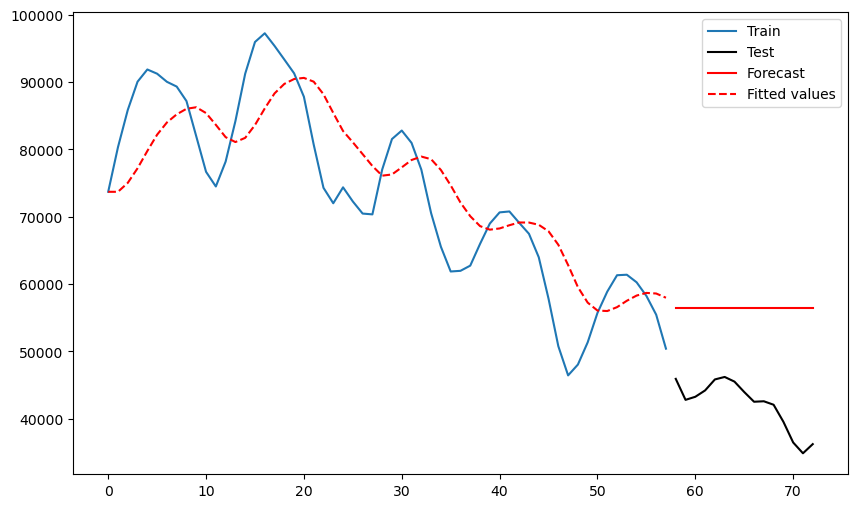

In [53]:
## Simple Exponential Smoothing
y_train, y_test = temporal_train_test_split(y, test_size=0.2)

print("Length of train set is " + str(y_train.shape[0]))
print("Length of test set is " + str(y_test.shape[0]))

fit1 = SimpleExpSmoothing(y_train).fit(smoothing_level=0.2, optimized=False)

fh = len(y_test)  # Forecast horizon
y_pred = fit1.forecast(fh)

plt.figure(figsize=(10, 6))
y_train.plot(label='Train')
y_test.plot(label='Test', color='black')
y_pred.plot(label='Forecast', color='red')
fit1.fittedvalues.plot(label='Fitted values', color='red', linestyle='--')
plt.legend()
plt.show()


In [55]:

def smape(y_true, y_pred):
    return 100 * (2 * abs(y_pred - y_true) / (abs(y_true) + abs(y_pred))).mean()

smape_result = smape(y_test, y_pred)
print(f'sMAPE: {smape_result:.2f}')

In [59]:
print(y_train[-5:])
print(y_pred[:5])

ValueError: y_pred and y_true do not have the same number of rows.

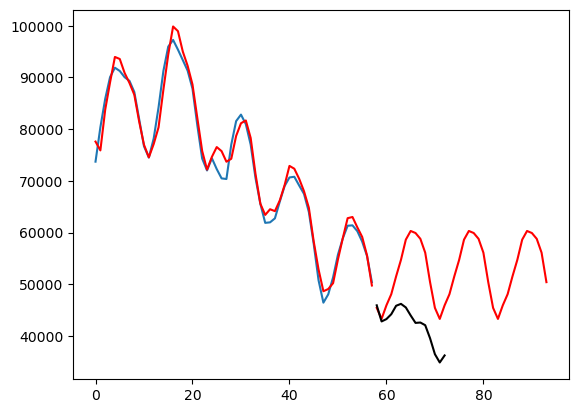

In [75]:
#Seasonality
fit6 = ExponentialSmoothing(y_train, 
                            seasonal_periods=12, 
                            seasonal='add'
                           ).fit()
# Forecast over testing period
y_pred6 = fit6.forecast(36)
# Plot the values
y_train.plot()
y_pred6.plot(color='red')
y_test.plot(color='black')
fit6.fittedvalues.plot(color='red')
# Calculate smape of test set performance
smape = MeanAbsolutePercentageError()
smape_result = smape(y_test, y_pred6)
print(f'smape: {smape_result}')

ValueError: y_pred and y_true do not have the same number of rows.

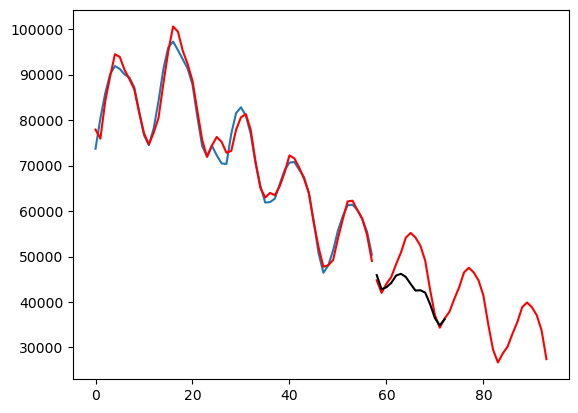

In [77]:
#Trend+Seasonality
# Fit the model, with selected alpha value
fit7 = ExponentialSmoothing(y_train,
                            trend='add',
                            seasonal_periods=12, 
                            seasonal='add'
                           ).fit()
# Forecast over testing period
y_pred7 = fit7.forecast(36)
# Plot the values
y_train.plot()
y_pred7.plot(color='red')
y_test.plot(color='black')
fit7.fittedvalues.plot(color='red')
# Calculate smape of test set performance
smape = MeanAbsolutePercentageError()
smape_result = smape(y_test, y_pred7 )
print(f'smape: {smape_result}')

In [80]:
differenced_data = (y-y.shift()).iloc[1:]

<Axes: >

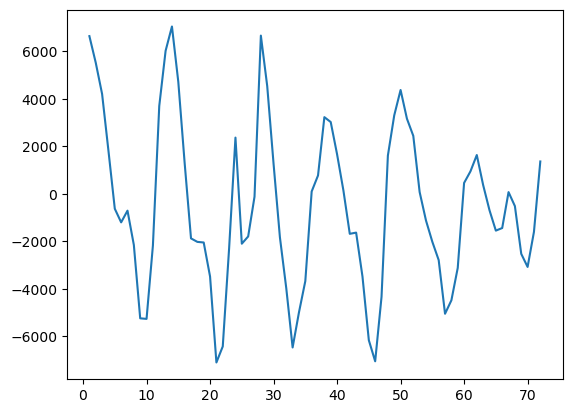

In [84]:
differenced_data.plot()

In [92]:
from scipy import stats
diff_trans_data, lambda_val = stats.boxcox(differenced_data)

ValueError: Data must be positive.

In [94]:
trans_data, lambda_val = stats.boxcox(y)
trans_data = pd.Series(trans_data)

In [97]:
trans_diff_data = (trans_data-trans_data.shift()).iloc[1:]

<Axes: >

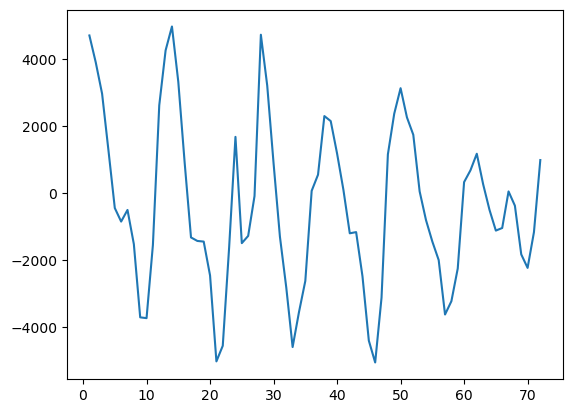

In [100]:
trans_diff_data.plot()

In [111]:
from sklearn.model_selection import train_test_split
y_train, y_test = train_test_split(trans_diff_data, test_size =0.25, shuffle=False)

In [114]:
y_train.index.min(), y_train.index.max()

(1, 54)

In [118]:
y_test.index.min(), y_test.index.max()

(55, 72)

In [121]:
from statsmodels.tsa.arima.model import ARIMA
arma_model = ARIMA(y_train, order=(1,0,1))

In [124]:
model_fit = arma_model.fit()
print(model_fit.summary())

<Axes: >

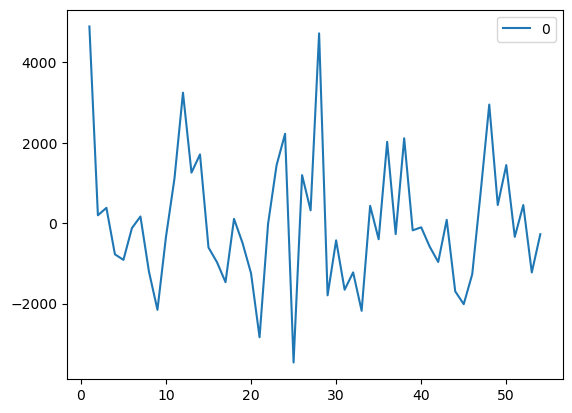

In [127]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

In [130]:
fh = list(range(1, 1+len(y_test)))

In [133]:
y_pred = model_fit.forecast()

<Axes: >

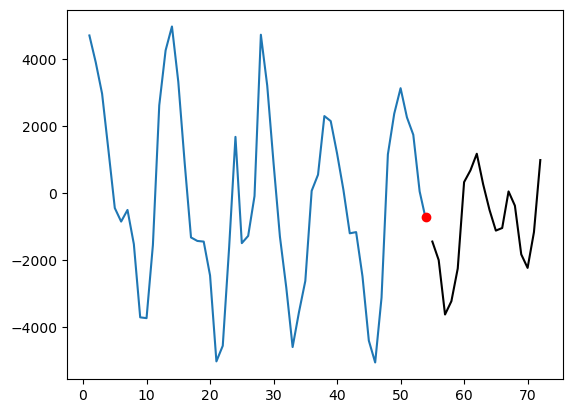

In [136]:
y_train.plot()
y_pred.plot(color='red', marker = 'o')
y_test.plot(color = 'black')

In [139]:
y_forecast = model_fit.predict(start=y_test.index.min(), end = y_test.index.max())

<Axes: >

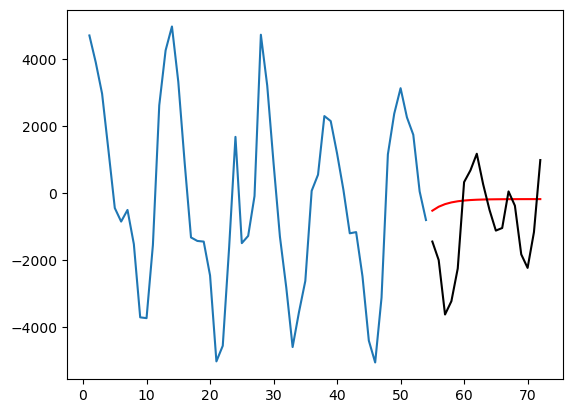

In [142]:
y_train.plot()
y_forecast.plot(color='red')
y_test.plot(color = 'black')

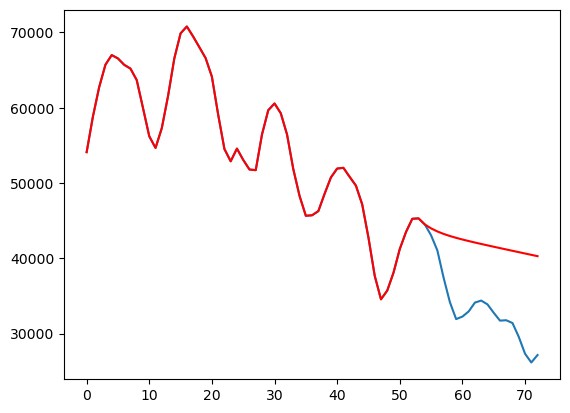

In [145]:
undiff_y = np.r_[trans_data[0], y_train, y_test].cumsum().astype('float64')
plt.plot(undiff_y)

undiff_forecast = np.r_[trans_data[0], y_train,  y_forecast].cumsum().astype('float64')
plt.plot(undiff_forecast, color='red')

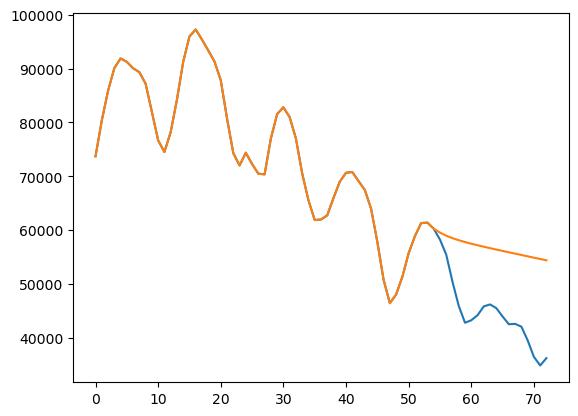

In [148]:
from scipy.special import inv_boxcox

inv_undiff_y = inv_boxcox(undiff_y, lambda_val)
plt.plot(inv_undiff_y)

inv_undiff_forecast = inv_boxcox(undiff_forecast, lambda_val)
plt.plot(inv_undiff_forecast)